# Notebook: Анализ и прогнозирование преждевременной потери активности студентов в EdTech продукте

Этот ноутбук посвящен исследованию факторов, влияющих на снижение активности пользователей и прогнозированию рисков оттока.

В общем, мы изучим данные об активности студентов, выполним предобработку, создадим признаки, обучим модели выживания и оценим их эффективность.

В этой ячейке импортируются основные библиотеки для работы с данными, обработки, моделирования и оценки результатов.

# -1. Подгрузка датасета из БД

In [1]:
dataset = '''placeholder, SQL code to DWH cannot be disclosed due to NDA''' # полный датасет признаков участников
dea = '''placeholder, SQL code to DWH cannot be disclosed due to NDA''' # дата отчисления

In [2]:
# dwh = create_engine(
#     "placeholder")

In [3]:
# dea = pd.DataFrame(dwh.connect().execute(text(dea)))

In [4]:
# df.to_csv('dimploma_dataset_28_05.csv')
# dea.to_csv('deactivated_at.csv')

# 1. Импорт необходимых библиотек

In [5]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine, text

## 2. Загрузка и предобработка данных

В этом разделе мы загружаем данные из файлов, заменяем кодированные значения и объединяем таблицы для дальнейшего анализа.

Сначала читаем основной датасет `dimploma_dataset_28_05.csv` и файл с датами деактивации `deactivated_at.csv`. После загрузки объединяем данные по столбцу `ldap_login`, заменяем отсутствующие значения на NaN и готовим таблицу.

In [6]:
df = pd.read_csv('dimploma_dataset_28_05.csv', index_col=0)
deactivated = pd.read_csv('deactivated_at.csv',  index_col=0)

In [8]:
df.head()

,ldap_login,wave_name,start_at,gender,is_local,age,virgin_developer,state,education_level,occupation,...,attendance_month4,attendance_month5,attendance_month6,attendance_month7,attendance_month8,attendance_month9,attendance_month10,attendance_month11,attendance_month12,event_count
0,bkrabapp,21_10_NSK,2021-10-28,Мужской,Регистрация в другом регионе,19,С опытом,Отчислен,secondary,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,staggana,21_10_NSK,2021-10-28,Мужской,Регистрация в регионе кампуса,28,Без опыта,Отчислен,higher,0,...,2.0,5.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN
2,pquordle,21_10_NSK,2021-10-28,Мужской,Регистрация в регионе кампуса,21,С опытом,Отчислен,secondary,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,aedie,21_10_NSK,2021-10-28,Мужской,Регистрация в регионе кампуса,31,Нет данных,Выпускник,higher,1,...,3.0,3.0,0.0,1.0,0.0,3.0,0.0,4.0,2.0,NaN
4,iayako,21_10_NSK,2021-10-28,Мужской,Регистрация в другом регионе,20,С опытом,Активен,secondary,10,...,16.0,11.0,8.0,1.0,0.0,0.0,0.0,0.0,16.0,2.0


In [9]:
df = df.merge(deactivated, how = 'left', on= 'ldap_login')

In [10]:
df.replace('Нет данных', np.nan, inplace=True)


## 3. Проверка и приведение типов данных

Убедимся, что столбцы имеют корректные типы: преобразуем даты в формат datetime, а остальные признаки приведем к нужному типу.

## 4. Применение One-Hot кодирования

Закодируем категориальные признаки, чтобы алгоритмы машинного обучения могли их корректно обрабатывать.

In [11]:
df = df.query("state != 'Возврат на выбор волны'")

In [12]:
df['is_local'] = df['is_local'].replace({'Регистрация в регионе кампуса': 1, 'Регистрация в другом регионе': 0, 'Нет данных': np.nan})
df['virgin_developer'] = df['virgin_developer'].replace({'С опытом': 1, 'Без опыта': 0, 'Нет данных': np.nan})
df['it_university_major'] = df['it_university_major'].replace({'IT специальность': 1, 'Не IT специальность': 0, 'Нет данных': np.nan})
df['education_level'] = df['education_level'].replace({'среднее': 0, 'среднее-специальное': 1,  'бакалавриат': 2, 'магистратура/специалитет': 3, "master\'s degree/specialty degree": 3, 'аспирантура и выше': 4, 'Нет данных': np.nan})
df['gender'] = df['gender'].replace({'Мужской': 0, 'Женский': 1})
df['state'] = df['state'].replace({'Активен': 1, 'Выпускник': 1, 'Отчислен': 0})

/var/folders/1n/4bqnbhld3hl49w2bcbd7qk0h0000gn/T/ipykernel_1266/2120367617.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_local'] = df['is_local'].replace({'Регистрация в регионе кампуса': 1, 'Регистрация в другом регионе': 0, 'Нет данных': np.nan})
/var/folders/1n/4bqnbhld3hl49w2bcbd7qk0h0000gn/T/ipykernel_1266/2120367617.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['virgin_developer'] = df['virgin_developer'].replace({'С опытом': 1, 'Без опыта': 0, 'Нет данных': np.nan})
/var/folders/1n/4bqnbhld3hl49w2bcbd7

In [13]:
df['gender'].fillna(df['gender'].mode()[0], inplace=True)
df['is_local'].fillna(df['is_local'].mode()[0], inplace=True)
df['virgin_developer'].fillna(df['virgin_developer'].mode()[0], inplace=True)
df['education_level'].fillna(df['education_level'].mode()[0], inplace=True)
df['it_university_major'].fillna(df['it_university_major'].mode()[0], inplace=True)
df['university_major_category'].fillna(df['university_major_category'].mode()[0], inplace=True)


/var/folders/1n/4bqnbhld3hl49w2bcbd7qk0h0000gn/T/ipykernel_1266/1546502605.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['gender'].fillna(df['gender'].mode()[0], inplace=True)
/var/folders/1n/4bqnbhld3hl49w2bcbd7qk0h0000gn/T/ipykernel_1266/1546502605.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

In [14]:
df.drop(df[df['xp'] > 50000].index, axis= 0, inplace = True)
df = df[df['age'] <= 100]


In [15]:
df = pd.get_dummies(df, columns=['university_major_category'], drop_first=True)  # One-hot encoding

## 5. Feature Engineering

Создаем новые признаки на основе исходных данных: рассчитываем метрики активности, взаимодействия студентов с продуктом и т.д.

In [16]:
df['start_at'] = pd.to_datetime(df['start_at'])
df['gender'] = df['gender'].astype('int64')

In [17]:
df['start_month'] = df['start_at'].dt.month

In [18]:
df['start_at'] = pd.to_datetime(df['start_at'])
df['deactivated_at'] = pd.to_datetime(df['deactivated_at'])
today = datetime.today()
df['days_since_start'] = (today - df['start_at']).dt.days
df['days_till_deactivation'] = (df['deactivated_at'] - df['start_at']).dt.days
df['attendance_rate'] = df['total_attendance'] / df['days_since_start']
df['attendance_rate'] = df['attendance_rate'].replace([np.inf, -np.inf], np.nan)
df['attendance_rate'] = df['attendance_rate'].fillna(0)

## 6. Масштабирование числовых признаков

Масштабируем числовые переменные, используя стандартизацию или нормализацию, чтобы алгоритмы учитывали их корректно.

In [20]:
# numeric_columns = df.select_dtypes(include=['float', 'int']).columns.tolist()

In [21]:
# numeric_columns

In [22]:
# exclude_columns = ['is_local', 'virgin_developer', 'it_university_major', 'education_level', 'gender', 'state', 'occupation', 'age']

In [23]:
# numeric_columns = [col for col in numeric_columns if col not in exclude_columns]

In [24]:
# scaler = StandardScaler()
# df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

## 7. Удаление дубликатов

Удаляем повторяющиеся строки в наборе данных, чтобы избежать искажения анализа.

In [25]:
df = df.drop_duplicates(subset=['ldap_login'], keep='first')


## 8. Формирование когорт исследования (23_10-24_11)

Выделяем когорты пользователей по временным волнам: от 23 октября до 24 ноября. Это позволит анализировать динамику оттока.

In [26]:
w23_10 = df[df['wave_name'].str.contains(r'23_10.', regex=True)]
w23_12 = df[df['wave_name'].str.contains(r'23_12.', regex=True)]
w24_04 = df[df['wave_name'].str.contains(r'24_04.', regex=True)]
w24_11 = df[df['wave_name'].str.contains(r'24_11.', regex=True)]
df_23_24 = pd.concat([w23_10, w23_12, w24_04, w24_11])

## 9. Определение функции для вычисления риска потери активности

Определяем функцию, которая рассчитывает вероятность оттока для каждого пользователя на основе выбранных признаков.

In [27]:
# Пороговые значения (при необходимости скорректировать)
attendance_threshold = 0.5
learning_threshold = df_23_24['mean_day_xp'].median()
p2p_threshold = df_23_24[['punctuality', 'friendliness', 'interest', 'thoroughness']].mean(axis=1).median()
social_threshold = df_23_24['avg_check_mins'].median()

def compute_risk(df):
    """
    Добавляет в DataFrame столбцы:
    - risk_score: суммарный риск по бинарным флагам
    - risk_metric: нормированная метрика риска
    - risk_level: квантильный уровень риска ('Low', 'Medium', 'High', 'Very High')
    """
    flags = pd.DataFrame({
        'attendance_flag': (df['attendance_rate'] < attendance_threshold).astype(int),
        'learning_flag':   (df['mean_day_xp'] < learning_threshold).astype(int),
        'p2p_flag':        (df[['punctuality','friendliness','interest','thoroughness']].mean(axis=1) < p2p_threshold).astype(int),
        'social_flag':     (df['avg_check_mins'] < social_threshold).astype(int)
    }, index=df.index)
    df['risk_score'] = flags.sum(axis=1)
    # Используем tenure_months, если есть
    if 'tenure_months' in df.columns:
        df['risk_metric'] = df['risk_score'] / (df['tenure_months'] + 1e-6)
    else:
        df['risk_metric'] = df['risk_score']
    df['risk_level'] = pd.qcut(df['risk_metric'], 4, labels=['Low','Medium','High','Very High'])
    return df

In [28]:
df_23_24 = compute_risk(df_23_24)

In [29]:
df = compute_risk(df)

In [31]:
# Просмотр топ-10 самых рисковых пользователей по синтетической метрике риска
top_risk = df_23_24[['ldap_login', 'wave_name','risk_metric','risk_level']].sort_values('risk_metric', ascending=False).head(10)
print("Топ-10 участников по риску потери активности:")
print(top_risk)

Топ-10 участников по риску потери активности:
      ldap_login   wave_name  risk_metric risk_level
5579    mayormar   23_10_KZN            4  Very High
7254    levinsos   24_04_MSK            4  Very High
9363    gargalem   24_11_NOV            4  Very High
9365    dunegylo   24_11_NOV            4  Very High
4679    michaecl   23_10_MSK            4  Very High
10290   ethylcap   24_11_KZN            4  Very High
6918    ammieoat   24_04_SRG            4  Very High
9371    crouchma  24_11_CHEL            4  Very High
6920    franzena   24_04_MSK            4  Very High
9372    albertiv   24_11_YKS            4  Very High


ROC AUC для risk_metric: 0.5878997208619843


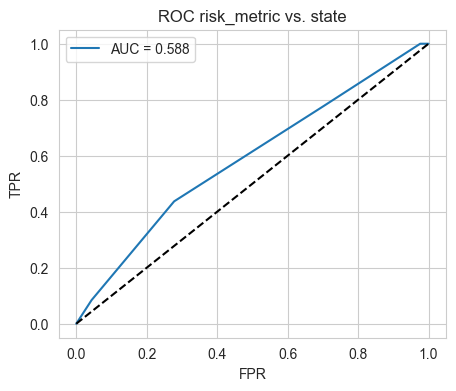

In [32]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# y_true: 1 — реальный отток (state==0), 0 — остался
y_true = (df_23_24['state'] == 0).astype(int)
scores = df_23_24['risk_metric']

# AUC
auc_risk = roc_auc_score(y_true, scores)
print("ROC AUC для risk_metric:", auc_risk)

# ROC-кривая
fpr, tpr, _ = roc_curve(y_true, scores)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'AUC = {auc_risk:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title('ROC risk_metric vs. state')
plt.legend(); plt.show()


## 10. Формирование матрицы признаков и целевой переменной

Генерируем матрицу признаков X и вектор таргета y для обучения моделей: определяем позитивные и негативные примеры.

In [33]:
# Целевая переменная: churn = 1, если state == 0 (отчислен), иначе 0
df_23_24['churn'] = (df_23_24['state'] == 0).astype(int)
y = df_23_24['churn']

## 11. Решаем поставленную задачу как задачу классификации с помощью Random Forest

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

In [36]:
# диагностика волн
print("Уникальные волны в df_23_24:", df_23_24['wave_name'].unique())
print(df_23_24['wave_name'].value_counts())

train_waves = ['23_10', '23_12']
test_waves  = ['24_04', '24_11']

mask_train = df_23_24['wave_name'].str.split('_').str[:2].str.join('_') \
    .isin(train_waves)
mask_test  = df_23_24['wave_name'].str.split('_').str[:2].str.join('_') \
    .isin(test_waves)

print(f"Записей в train волнах {train_waves}: {mask_train.sum()}")
print(f"Записей в test  волнах {test_waves}: {mask_test.sum()}")

# train/test датасеты
df_train = df_23_24.loc[mask_train].copy()
df_test  = df_23_24.loc[mask_test].copy()

# списки признаков
datetime_features = ['start_month', 'days_since_start']

all_candidate_numeric = [
    'age','punctuality','friendliness','interest','thoroughness',
    'avg_check_mins','number_of_verifiable_p2p','avg_verifiable_minutes',
    'number_of_verifier_p2p','avg_verifier_minutes','success','fail',
    'in_progress','avg_final_perc','xp','lvl','all_xp','mean_day_xp',
    'q1_xp','q2_xp','total_attendance','attendance_q1','attendance_q2',
    'attendance_q3','attendance_q4','attendance_h1','attendance_h2',
    'attendance_h3','attendance_month1','attendance_month2','attendance_month3',
    'attendance_month4','attendance_month5','attendance_month6','attendance_month7',
    'attendance_month8','attendance_month9','attendance_month10',
    'attendance_month11','attendance_month12','event_count',
    'attendance_rate','risk_score','risk_metric',
    'gender','is_local','virgin_developer'
]

all_candidate_categorical = [
    'occupation','it_university_major',
    'university_major_category_Гуманитарные науки',
    'university_major_category_Другое',
    'university_major_category_Здравоохранение и медицинские науки',
    'university_major_category_Инженерное дело, технологии и технические науки',
    'university_major_category_Искусство и культура',
    'university_major_category_Математические и естественные науки',
    'university_major_category_Науки об обществе',
    'university_major_category_Образование и педагогические науки',
    'university_major_category_Сельское хозяйство и с/х науки'
]
numeric_features = [
    c for c in all_candidate_numeric
    if pd.api.types.is_numeric_dtype(df_23_24[c])
]
categorical_features = [
                           c for c in all_candidate_numeric
                           if c not in numeric_features
                       ] + all_candidate_categorical

feature_cols = numeric_features + datetime_features + categorical_features

X_train = df_train[feature_cols]
y_train = df_train['churn']
X_test  = df_test[feature_cols]
y_test  = df_test['churn']

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

#шаг предобработки и конвейер
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale',  StandardScaler())
    ]), numeric_features + datetime_features),

    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ohe',    OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_features)
,
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('clf',  RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        class_weight='balanced',
        random_state=42))
])

#обучение и оценка
pipeline.fit(X_train, y_train)
y_proba = pipeline.predict_proba(X_test)[:,1]
y_pred  = pipeline.predict(X_test)

print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


Уникальные волны в df_23_24: ['23_10_MSK' '23_10_SRG' '23_10_KZN' '23_10_NSK' '23_12_MSK' '23_12_NOV'
 '24_04_NSK' '24_04_KZN' '24_04_MSK' '24_04_SRG' '24_11_SAKH' '24_11_MSK'
 '24_11_MAG' '24_11_KZN' '24_11_NSK' '24_11_SRG' '24_11_NOV' '24_11_YAR'
 '24_11_BELGOROD' '24_11_YKS' '24_11_CHEL']
wave_name
24_11_MSK         1065
23_10_MSK          823
24_04_MSK          516
23_10_KZN          415
24_11_KZN          363
23_12_MSK          349
24_11_NSK          316
23_10_NSK          306
24_04_KZN          263
24_04_NSK          234
24_11_MAG          171
24_11_NOV          161
24_11_CHEL         130
24_11_YAR          128
23_12_NOV          126
23_10_SRG          105
24_11_BELGOROD      87
24_11_SRG           86
24_11_YKS           86
24_04_SRG           80
24_11_SAKH          50
Name: count, dtype: int64
Записей в train волнах ['23_10', '23_12']: 2124
Записей в test  волнах ['24_04', '24_11']: 3736
Train samples: 2124, Test samples: 3736
ROC AUC: 0.88665743445534
              precision   

## 12. Определение оптимального порога для Recall

Подбираем порог вероятности для максимизации Recall при приемлемом значении Precision.

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
results = []
for thresh in np.arange(0.1, 1.0, 0.05):
    y_pred_t = (y_proba >= thresh).astype(int)
    prec = precision_score(y_test, y_pred_t, zero_division=0)
    rec  = recall_score(y_test, y_pred_t)
    f1   = f1_score(y_test, y_pred_t)
    results.append((thresh, prec, rec, f1))

df_thr = pd.DataFrame(results, columns=['threshold','precision','recall','f1'])
print(df_thr)

#найдём порог, при котором recall ~ 0.90–0.95
target_recall = 0.90
cand = df_thr[df_thr['recall'] >= target_recall]
print("\nКандидаты для recall >=", target_recall)
print(cand)

best_thresh = cand['threshold'].iloc[-1]
print(f"\nИспользуем threshold = {best_thresh:.2f}")

#классификация на этом пороге
y_pred_sel = (y_proba >= best_thresh).astype(int)
print(classification_report(y_test, y_pred_sel))


    threshold  precision    recall        f1
0        0.10   0.215427  1.000000  0.354488
1        0.15   0.218802  1.000000  0.359045
2        0.20   0.222475  1.000000  0.363975
3        0.25   0.226535  1.000000  0.369391
4        0.30   0.230678  1.000000  0.374880
5        0.35   0.234675  0.998721  0.380049
6        0.40   0.238838  0.998721  0.385489
7        0.45   0.242396  0.998721  0.390110
8        0.50   0.246212  0.997442  0.394937
9        0.55   0.252758  0.996164  0.403209
10       0.60   0.260389  0.993606  0.412639
11       0.65   0.272952  0.988491  0.427781
12       0.70   0.287538  0.979540  0.444573
13       0.75   0.315222  0.971867  0.476041
14       0.80   0.362793  0.950128  0.525088
15       0.85   0.452536  0.890026  0.600000
16       0.90   0.590909  0.714834  0.646991
17       0.95   0.751381  0.347826  0.475524

Кандидаты для recall >= 0.9
    threshold  precision    recall        f1
0        0.10   0.215427  1.000000  0.354488
1        0.15   0.218802  

# 13. Формируем датасет для survival-моделлирования df_sa

In [38]:
#копируем данные и заменяем «Нет данных» на NaN
df_sa = df.copy()
df_sa.replace('Нет данных', np.nan, inplace=True)

#приводим даты в нужный формат и вычисляем t/e через разницу дат
df_sa['start_at']       = pd.to_datetime(df_sa['start_at'])
df_sa['deactivated_at'] = pd.to_datetime(df_sa['deactivated_at'], errors='coerce')

#дата цензуры (максимальная из deactivated_at)
censor_date = df_sa['deactivated_at'].max()

#event_time: если deactivated_at отсутствует, ставим censor_date
df_sa['event_time'] = df_sa['deactivated_at'].fillna(censor_date)

#считаем t (в днях) и e (1 = событие произошло, 0 = цензура)
df_sa['T'] = (df_sa['event_time'] - df_sa['start_at']).dt.days.clip(lower=1)
df_sa['E'] = df_sa['deactivated_at'].notna().astype(int)

#вычисляем per-day признаки на основе финального t
df_sa['xp_per_day']                = df_sa['all_xp'] / df_sa['T']
df_sa['events_per_day']            = df_sa['event_count'] / df_sa['T']
df_sa['verifier_sessions_per_day'] = df_sa['number_of_verifier_p2p'] / df_sa['T']
df_sa['verifier_minutes_per_day']  = df_sa['avg_verifier_minutes']   / df_sa['T']
df_sa['verifiable_minutes_per_day'] = df_sa['avg_verifiable_minutes'] / df_sa['T']
df_sa['fail_per_day']              = df_sa['fail'] / df_sa['T']
df_sa['in_progress_per_day']       = df_sa['in_progress'] / df_sa['T']
df_sa['attendance_per_day']        = df_sa['total_attendance'] / df_sa['T']

#приводим attendance_rate и risk_metric к числовому типу
df_sa['attendance_rate'] = pd.to_numeric(df_sa['attendance_rate'], errors='coerce')
df_sa['risk_metric']     = pd.to_numeric(df_sa['risk_metric'],   errors='coerce')

#агрегаты посещаемости по месяцам (1–12)
months = [f'attendance_month{i}' for i in range(1, 13)]
for m in months:
    df_sa[m] = pd.to_numeric(df_sa[m], errors='coerce')

_month_idx = np.arange(1, 13)
df_sa['att_trend']      = df_sa[months].apply(
    lambda r: np.polyfit(_month_idx[~r.isna()], r.dropna(), 1)[0]
    if r.dropna().size > 1 else np.nan,
    axis=1
)
df_sa['att_dispersion'] = df_sa[months].std(axis=1)
df_sa['att_early']      = df_sa[[f'attendance_month{i}' for i in range(1, 5)]].mean(axis=1)
df_sa['att_middle']     = df_sa[[f'attendance_month{i}' for i in range(5, 9)]].mean(axis=1)
df_sa['att_late']       = df_sa[[f'attendance_month{i}' for i in range(9, 13)]].mean(axis=1)

#логарифмическое преобразование некоторых признаков
df_sa['log_verif_min_per_day']     = np.log1p(df_sa['verifier_minutes_per_day'])
df_sa['verifiable_minutes_per_day'] = np.log1p(df_sa['verifiable_minutes_per_day'])
df_sa['events_per_day']            = np.log1p(df_sa['events_per_day'])
df_sa['fail_per_day']              = np.log1p(df_sa['fail_per_day'])
df_sa['in_progress_per_day']       = np.log1p(df_sa['in_progress_per_day'])


## Смотрим распоеделение отчислений для подбора оптимального горизонта прогнозирования

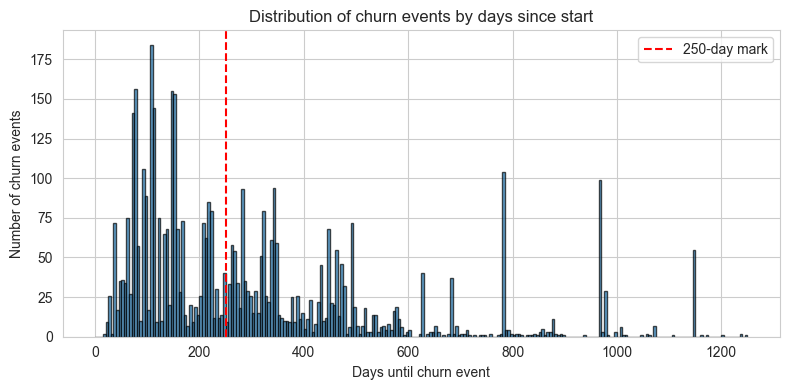

In [39]:
event_times = df_sa.loc[df_sa['E'] == 1, 'T']

plt.figure(figsize=(8,4))
# бины по 5 дней: 0–5, 5–10, … до максимальной длительности
bins = range(0, int(event_times.max()) + 5, 5)
plt.hist(event_times, bins=bins, edgecolor='black', alpha=0.7)
plt.axvline(250, color='red', linestyle='--', label='250-day mark')
plt.xlabel('Days until churn event')
plt.ylabel('Number of churn events')
plt.title('Distribution of churn events by days since start')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
#возьмём времена отчисления
event_times = df_sa.loc[df_sa['E'] == 1, 'T']

#список перцентилей, которые хотим посмотреть
percentiles = [30, 40, 50, 60, 70, 80, 90]

#вычисляем дни для каждого перцентиля
days = np.percentile(event_times, percentiles).astype(int)
df_pct = pd.DataFrame({
    'Percentile (%)': percentiles,
    'Days until churn': days
})
display(df_pct)

,Percentile (%),Days until churn
0,30,133
1,40,157
2,50,220
3,60,281
4,70,342
5,80,456
6,90,628


# 13. Переход к survival-анализу для решения задачи.
Cox Proportional Hazards (CoxPH) — это «полу-параметрическая» модель для анализа времени до события (в нашем случае — «дней до отчисления»). Простыми словами, она учится оценивать относительный риск (hazard) каждого студента, опираясь на признаки, без необходимости задавать точную форму функции базового риска во времени.

# Как работает CoxPH на наших данных

## Время до события

У каждого студента есть:

- **$T$** — число дней с момента старта до отчисления (или до цензуры, если он ещё не отчислен).
- **$E \in \{0, 1\}$** — индикатор события:
  - $1$, если студент отчислился;
  - $0$, если он «дожил» до конца наблюдения.

## Модель относительного риска

CoxPH предполагает, что риск отчисления в момент $t$ у студента с вектором признаков $\mathbf{x} = (x_1, x_2, \dots, x_p)$ равен:

$$
h(t \mid \mathbf{x}) = h_{0}(t)\,\exp\!\bigl(\beta_{1}x_{1} + \beta_{2}x_{2} + \cdots + \beta_{p}x_{p}\bigr),
$$

где:

- $h_{0}(t)$ — **базовый риск** (неизвестная функция времени).
- $\exp(\beta_{i} x_{i})$ — **множитель риска**, зависящий от признаков студента.

Ваша задача — оценить коэффициенты $\beta = (\beta_{1}, \beta_{2}, \dots, \beta_{p})$ так, чтобы наиболее «опасным» (с высоким hazard) студентам соответствовало меньшее время до отчисления.

### Объяснение терминов

1. **$h(t \mid \mathbf{x})$** — функция риска (hazard function) для студента с признаками $\mathbf{x}$ в момент времени $t$.
2. **$h_{0}(t)$** — базовый (нормативный) риск, общий для всех студентов, если бы у них отсутствовали признаки (или при $x_i = 0$ для всех $i$).
3. **$\exp(\beta_{1}x_{1} + \dots + \beta_{p}x_{p})$** — множитель, который масштабирует базовый риск в зависимости от набора признаков студента.

## Пример интерпретации

Предположим, в нашей модели есть признак `attendance_rate` с оценённым коэффициентом $\beta = -1.97$.

1. Вычислим
   $$
   \exp(\beta) = e^{-1.97} \approx 0.14.
   $$
2. Это означает, что при прочих равных условиях увеличение посещаемости на 1 единицу (например, переход от 0.8 → 1.8) уменьшает риск отчисления примерно в 7 раз.

Аналогично, для признака `verifier_minutes_per_day` оценённый $\beta \approx +14.7$. Тогда

$$
\exp(\beta) = e^{14.7} \gg 1,
$$

и «долгие» проверки чужого кода резко увеличивают hazard (риск отчисления).

## Что даёт CoxPH

1. **Относительный risk score**:
   $$
   \text{partial_hazard} = \exp(\mathbf{x} \cdot \beta).
   $$
   Это число показывает, насколько данный студент более «уязвим» (или «защищён») по сравнению с базовым риском.

2. **Кривые выживания**
   $$
   S(t \mid \mathbf{x}) = \Pr\bigl(T > t \mid \mathbf{x}\bigr),
   $$
   где $S(t \mid \mathbf{x})$ — вероятность того, что студент не отчислится до момента $t$.
   На практике эти кривые строятся с учётом оценённых коэффициентов и наблюдений (используется базовый кумулятивный риск, затем вычисляется $S(t \mid \mathbf{x})$ для различных $t$).

3. **Concordance Index (C-index)** как метрика качества ранжирования:
   Доля правильно упорядоченных пар студентов по времени до события (учитываются только сравнимые пары, где один из студентов действительно отчислился раньше другого).

## Ограничения CoxPH

1. **Пропорциональность рисков**
   Модель предполагает, что отношение рисков двух студентов
   $$
   \frac{h(t \mid \mathbf{x}_i)}{h(t \mid \mathbf{x}_j)}
   $$
   не зависит от времени $t$. Если это допущение нарушается, оценки коэффициентов могут быть смещены, а модель плохо описывать данные.

2. **Линейность в лог-hazard**
   В экспоненте стоит линейная комбинация признаков:
   $$
   \beta_{1}x_{1} + \beta_{2}x_{2} + \cdots + \beta_{p}x_{p}.
   $$
   Если зависимость между признаками и риском сложнее (взаимодействия, нелинейности), CoxPH может недооценивать или переоценивать эффект отдельных признаков.

Когда эти допущения не выполняются или нужны более сложные взаимодействия, обычно используют альтернативные методы (например, случайные леса для выживания, нейросети выживания и т. д.).


In [41]:
from lifelines import CoxPHFitter
#подготовка T и E
df_sa = df_23_24.copy()
df_sa.replace('Нет данных', np.nan, inplace=True)
df_sa['T'] = df_sa['days_since_start'].replace(0, 1)
df_sa['E'] = (df_sa['state'] == 0).astype(int)

#нормировка «на день»
df_sa['xp_per_day']                  = df_sa['all_xp'] / df_sa['T']
df_sa['events_per_day']              = df_sa['event_count'] / df_sa['T']
# df_sa['verifiable_sessions_per_day'] = df_sa['number_of_verifiable_p2p'] / df_sa['T']
df_sa['verifier_sessions_per_day']   = df_sa['number_of_verifier_p2p'] / df_sa['T']
# df_sa['verifiable_minutes_per_day']  = df_sa['avg_verifiable_minutes'] / df_sa['T']
df_sa['verifier_minutes_per_day']    = df_sa['avg_verifier_minutes'] / df_sa['T']
# df_sa['success_per_day']             = df_sa['success'] / df_sa['T']
# df_sa['fail_per_day']                = df_sa['fail'] / df_sa['T']
# df_sa['in_progress_per_day']         = df_sa['in_progress'] / df_sa['T']
df_sa['attendance_per_day']          = df_sa['total_attendance'] / df_sa['T']

#список признаков
features = [
'attendance_rate',
    'events_per_day',
    'verifier_sessions_per_day',
    'verifier_minutes_per_day'
]

#убираем признаки с нулевой или очень низкой дисперсией
vars_ = df_sa[features].var()
features_clean = [f for f in features if vars_[f] > 1e-6]
print("Используемые фичи:", features_clean)

#собираем датасет для обучения и убеждаемся, что он не пуст
df_model = df_sa[['T','E'] + features_clean].dropna()
print("df_model.shape:", df_model.shape)

#обучаем CoxPH
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_model, duration_col='T', event_col='E')
cph.print_summary()


Используемые фичи: ['attendance_rate', 'events_per_day', 'verifier_sessions_per_day', 'verifier_minutes_per_day']
df_model.shape: (4355, 6)


<lifelines.CoxPHFitter: fitted with 4355 total observations, 3427 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 4355
number of events observed = 928
   partial log-likelihood = -6602.05
         time fit was run = 2025-06-02 07:11:41 UTC

---
                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                  
attendance_rate           -2.06      0.13      0.21           -2.48           -1.65                0.08                0.19
events_per_day            -4.84      0.01      0.74           -6.28           -3.39                0.00                0.03
verifier_sessions_per_day -2.03      0.13      0.24           -2.50           -1.57                0.08                0.21
verifier_minutes_per_day   5.59    266.74      1.30            3.05            8.13               21.01             3386.54

                           cmp to     z      p  -log2(p)
covariate                                               
attendance_rate              0.00 -9.70 <0.005     71.46
events_per_day               0.00 -6.56 <0.005     34.14
verifier_sessions_per_day    0.00 -8.55 <0.005     56.17
verifier_minutes_per_day     0.00  4.31 <0.005     15.89
---
Concordance = 0.76
Partial AIC = 13212.09
log-likelihood ratio test = 338.09 on 4 df
-log2(p) of ll-ratio test = 236.47

In [42]:
#дисперсии
df_tmp = df_sa[['T','E'] + features].dropna()
variances = df_tmp[features].var().sort_values()
print("Дисперсии признаков:")
print(variances.to_frame('variance'))


Дисперсии признаков:
                           variance
verifier_minutes_per_day   0.000703
events_per_day             0.002752
verifier_sessions_per_day  0.025378
attendance_rate            0.031734


### подбираем оптимальный список параметров для модели

In [43]:
#пусть в variances мы увидели, что fail_per_day и in_progress_per_day ~ 0
low_var_feats = variances[variances < 1e-8].index.tolist()
print("Будем отбрасывать (var<1e-8):", low_var_feats)

#оставляем всё остальное
features_clean = [f for f in features if f not in low_var_feats]
print("Окончательный список фичей:", features_clean)


Будем отбрасывать (var<1e-8): []
Окончательный список фичей: ['attendance_rate', 'events_per_day', 'verifier_sessions_per_day', 'verifier_minutes_per_day']


In [44]:
#формируем df_model уже с очищенным списком
df_model = df_sa[['T','E'] + features_clean].dropna()
print("df_model.shape:", df_model.shape)

#обучаем CoxPH с L2-регуляризацией
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_model, duration_col='T', event_col='E')
summary_df = cph.summary  # в старых версиях lifelines это cph.summary_
display(summary_df)

df_model.shape: (4355, 6)


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
attendance_rate,-2.063284,0.127036,0.212752,-2.480271,-1.646297,0.083721,0.192762,0.0,-9.698061,3.072833e-22,71.462849
events_per_day,-4.835694,0.007941,0.736792,-6.279779,-3.391608,0.001874,0.033655,0.0,-6.563176,5.267363e-11,34.144128
verifier_sessions_per_day,-2.033892,0.130825,0.237897,-2.500162,-1.567622,0.082072,0.208541,0.0,-8.549458,1.236676e-17,56.166310
verifier_minutes_per_day,5.586287,266.743420,1.296593,3.045012,8.127563,21.010279,3386.535309,0.0,4.308436,1.644133e-05,15.892314


In [45]:

#предсказанный относительный риск (partial hazard)
df_sa['risk_score'] = cph.predict_partial_hazard(df_sa[features_clean])

#survival probability на фиксированном горизонте t0:
t0 = 250  # дни
surv = cph.predict_survival_function(df_sa[features_clean], times=[t0])
df_sa['surv_250d'] = surv.iloc[0].values
df_sa['risk_250d'] = 1 - df_sa['surv_250d']

In [46]:
print("Concordance index:", cph.concordance_index_)

Concordance index: 0.7597596711990862


In [47]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, classification_report
#собираем маску «чистых» записей, где нет NaN в скоре и в метке
mask = (~df_sa['risk_score'].isna()) & (~df_sa['risk_250d'].isna())
mask_hazard = ~df_sa['risk_score'].isna()
mask_250d    = ~df_sa['risk_250d'].isna()

#истинные метки для hazard
y_true_h = y_true.loc[mask_hazard]
y_score_h = df_sa['risk_score'].loc[mask_hazard]

#ROC AUC по relative hazard
auc_hazard = roc_auc_score(y_true_h, y_score_h)
print("ROC AUC (hazard):", auc_hazard)

#истинные метки для 250-day risk
y_true_250 = y_true.loc[mask_250d]
y_score_250 = df_sa['risk_250d'].loc[mask_250d]

auc_250d = roc_auc_score(y_true_250, y_score_250)
print("ROC AUC (250d risk):", auc_250d)

#Precision–Recall для hazard
precision, recall, thresh = precision_recall_curve(y_true_h, y_score_h)

#вывод classification_report при каком-то пороге
best_thresh =  np.percentile(y_score_h, 75)  # порог 75-й перцентиль
y_pred_h = (y_score_h >= best_thresh).astype(int)
print(classification_report(y_true_h, y_pred_h))


ROC AUC (hazard): 0.8339701269331778
ROC AUC (250d risk): 0.8339701269331778
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      3427
           1       0.54      0.63      0.58       928

    accuracy                           0.81      4355
   macro avg       0.72      0.74      0.73      4355
weighted avg       0.82      0.81      0.81      4355



In [48]:
K = 200
top_idxs = df_sa['risk_score'].nlargest(K).index
precision_at_k = y_true.loc[top_idxs].mean()
print(f"Precision@{K} = {precision_at_k:.3f}")


Precision@200 = 0.550


## обучаю модель без даты отчисления

In [49]:
df_sa = df_23_24.copy()
df_sa.replace('Нет данных', np.nan, inplace=True)

#время и событие
df_sa['T'] = df_sa['days_since_start'].replace(0, 1) # T — продолжительность (в днях или единицах времени) до события или цензуры.
df_sa['E'] = (df_sa['state'] == 0).astype(int) # E — индикатор события (1 – произошло, 0 – цензура).

#per-day признаки
df_sa['events_per_day']            = df_sa['event_count'] / df_sa['T']
df_sa['verifier_sessions_per_day'] = df_sa['number_of_verifier_p2p'] / df_sa['T']
df_sa['verifier_minutes_per_day']  = df_sa['avg_verifier_minutes']   / df_sa['T']
df_sa['attendance_per_day']        = df_sa['total_attendance']      / df_sa['T']

#относительная посещаемость и агрегатная метрика риска
df_sa['attendance_rate'] = pd.to_numeric(df_sa['attendance_rate'], errors='coerce')
df_sa['risk_metric']     = pd.to_numeric(df_sa['risk_metric'],   errors='coerce')

#агрегированные attendance-тренды
#по месяцам
months = [f'attendance_month{i}' for i in range(1,13)]
for m in months:
    df_sa[m] = pd.to_numeric(df_sa[m], errors='coerce')

#Тренд посещаемости (наклон линейной регрессии по месяцам)
_month_idx = np.arange(1,13)
def month_trend(row):
    vals = row.values
    if np.isnan(vals).all(): return np.nan
    return np.polyfit(_month_idx[~np.isnan(vals)], vals[~np.isnan(vals)], 1)[0]

df_sa['att_trend']    = df_sa[months].apply(month_trend, axis=1)
df_sa['att_dispersion'] = df_sa[months].std(axis=1)

#Early/Mid/Late посещаемость
df_sa['att_early']  = df_sa[[f'attendance_month{i}' for i in range(1,5)]].mean(axis=1)
df_sa['att_middle'] = df_sa[[f'attendance_month{i}' for i in range(5,9)]].mean(axis=1)
df_sa['att_late']   = df_sa[[f'attendance_month{i}' for i in range(9,13)]].mean(axis=1)

features = [
    'events_per_day',
    'verifier_sessions_per_day','verifier_minutes_per_day',
    'attendance_per_day',
    'attendance_rate','risk_metric',
    'att_trend','att_dispersion',
    'att_early','att_middle','att_late'
]

df_tmp = df_sa[['T','E'] + features].dropna()
variances = df_tmp[features].var()
features_clean = [f for f in features if variances[f] > 1e-6]
print("Используемые признаки:", features_clean)
print("Размер выборки для обучения:", df_tmp.shape)

df_model = df_tmp[['T','E'] + features_clean]
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_model, duration_col='T', event_col='E')

summary_df = cph.summary  # в старых версиях lifelines это cph.summary_
display(summary_df)
print("Concordance index:", cph.concordance_index_)


Используемые признаки: ['events_per_day', 'verifier_sessions_per_day', 'verifier_minutes_per_day', 'attendance_per_day', 'attendance_rate', 'risk_metric', 'att_trend', 'att_dispersion', 'att_early', 'att_middle', 'att_late']
Размер выборки для обучения: (4084, 13)


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
events_per_day,-3.005661,0.049506,0.770941,-4.516677,-1.494645,0.010925,0.224328,0.0,-3.898693,9.671322e-05,13.335927
verifier_sessions_per_day,-1.490485,0.225263,0.246793,-1.974191,-1.006779,0.138874,0.365394,0.0,-6.039403,1.546850e-09,29.268019
verifier_minutes_per_day,8.302274,4033.032107,1.369396,5.618308,10.986240,275.422938,59055.894498,0.0,6.062729,1.338311e-09,29.476939
attendance_per_day,-0.703805,0.494699,0.258520,-1.210495,-0.197115,0.298050,0.821097,0.0,-2.722437,6.480248e-03,7.269735
attendance_rate,-0.703805,0.494699,0.258520,-1.210495,-0.197115,0.298050,0.821097,0.0,-2.722437,6.480248e-03,7.269735
risk_metric,0.596037,1.814912,0.034706,0.528015,0.664059,1.695564,1.942662,0.0,17.174039,4.154791e-66,217.192478
att_trend,-0.058212,0.943450,0.059884,-0.175582,0.059158,0.838969,1.060943,0.0,-0.972079,3.310111e-01,1.595049
att_dispersion,-0.029390,0.971038,0.014151,-0.057125,-0.001655,0.944476,0.998346,0.0,-2.076943,3.780681e-02,4.725210
att_early,-0.014471,0.985633,0.006729,-0.027659,-0.001282,0.972720,0.998718,0.0,-2.150542,3.151236e-02,4.987938


Concordance index: 0.8485528613885349


## обучаю модель с датой отчисления

In [50]:

#даты в нужный формат
df_sa['start_at']       = pd.to_datetime(df_sa['start_at'])
df_sa['deactivated_at'] = pd.to_datetime(df_sa['deactivated_at'], errors='coerce')

#дата цензуры
censor_date = df_sa['deactivated_at'].max()

#T и E
df_sa['event_time'] = df_sa['deactivated_at'].fillna(censor_date)
df_sa['T'] = (df_sa['event_time'] - df_sa['start_at']).dt.days.clip(lower=1)
df_sa['E'] = df_sa['deactivated_at'].notna().astype(int)

#фичи
df_sa['verifier_sessions_per_day'] = df_sa['number_of_verifier_p2p']/ df_sa['T']
df_sa['verifier_minutes_per_day']  = df_sa['avg_verifier_minutes']   / df_sa['T']
df_sa['verifiable_minutes_per_day']  = df_sa['avg_verifiable_minutes']   / df_sa['T']
df_sa['events_per_day']            = df_sa['event_count'] / df_sa['T']
df_sa['fail_per_day']                = df_sa['fail'] / df_sa['T']
df_sa['in_progress_per_day']         = df_sa['in_progress'] / df_sa['T']
df_sa['attendance_rate']           = pd.to_numeric(df_sa['attendance_rate'], errors='coerce')
df_sa['risk_metric']               = pd.to_numeric(df_sa['risk_metric'],   errors='coerce')

#агрегаты посещаемости по месяцам
months = [f'attendance_month{i}' for i in range(1,13)]
for m in months:
    df_sa[m] = pd.to_numeric(df_sa[m], errors='coerce')
_month_idx = np.arange(1,13)
df_sa['att_trend']      = df_sa[months].apply(
    lambda r: np.polyfit(_month_idx[~r.isna()], r.dropna(), 1)[0]
    if r.dropna().size>1 else np.nan,
    axis=1
)
df_sa['att_dispersion'] = df_sa[months].std(axis=1)
df_sa['att_early']      = df_sa[[f'attendance_month{i}' for i in range(1,5)]].mean(axis=1)
df_sa['att_middle']     = df_sa[[f'attendance_month{i}' for i in range(5,9)]].mean(axis=1)
df_sa['att_late']       = df_sa[[f'attendance_month{i}' for i in range(9,13)]].mean(axis=1)
df_sa['log_verif_min_per_day'] = np.log1p(df_sa['verifier_minutes_per_day'])
df_sa['verifiable_minutes_per_day'] = np.log1p(df_sa['verifiable_minutes_per_day'])
df_sa['events_per_day']            = np.log1p(df_sa['events_per_day'])
df_sa['fail_per_day']                = np.log1p(df_sa['fail_per_day'])
df_sa['in_progress_per_day']         = np.log1p(df_sa['in_progress_per_day'])
#финальный список признаков
features = [
    'verifier_minutes_per_day',
    'verifier_sessions_per_day',
    'attendance_rate',   # или attendance_per_day
    'risk_metric',
    'att_dispersion',
    'att_late',
    'in_progress_per_day',
    'fail_per_day',
    'verifiable_minutes_per_day',
    'events_per_day'
]

#подготовка датасета
df_model = df_sa[['T','E'] + features].dropna().reset_index(drop=True)

#отбросим колонки с почти нулевой дисперсией
vars_ = df_model[features].var()
features_clean = [f for f in features if vars_[f] > 1e-6]
print("Будем обучать на признаках:", features_clean)
print("Размер обучающей выборки:", df_model.shape)

df_model = df_model[['T','E'] + features_clean]

#обучаем CoxPH
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_model, duration_col='T', event_col='E')

#результаты
summary_df = cph.summary        # это pandas.DataFrame с coef, exp(coef), p-value и т.д.
display(summary_df)             # отобразит все строки
print("Concordance index:", cph.concordance_index_)


Будем обучать на признаках: ['verifier_minutes_per_day', 'verifier_sessions_per_day', 'attendance_rate', 'risk_metric', 'att_dispersion', 'att_late', 'in_progress_per_day', 'fail_per_day', 'verifiable_minutes_per_day', 'events_per_day']
Размер обучающей выборки: (3798, 12)


/Users/a.fedorova/Library/Python/3.10/lib/python/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['in_progress_per_day', 'fail_per_day'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
verifier_minutes_per_day,14.981246,3.208282e+06,0.843025,13.328948,16.633544,6.147357e+05,1.674390e+07,0.0,17.770824,1.189317e-70,232.284834
verifier_sessions_per_day,-0.319039,7.268472e-01,0.202703,-0.716330,0.078252,4.885417e-01,1.081396e+00,0.0,-1.573920,1.155060e-01,3.113960
attendance_rate,-1.293314,2.743599e-01,0.246015,-1.775495,-0.811134,1.693996e-01,4.443540e-01,0.0,-5.257054,1.463816e-07,22.703763
risk_metric,0.554247,1.740629e+00,0.039211,0.477394,0.631099,1.611869e+00,1.879675e+00,0.0,14.134941,2.313271e-45,148.276830
att_dispersion,-0.011694,9.883738e-01,0.012899,-0.036976,0.013587,9.636994e-01,1.013680e+00,0.0,-0.906605,3.646156e-01,1.455552
att_late,-0.043836,9.571105e-01,0.008697,-0.060882,-0.026790,9.409339e-01,9.735652e-01,0.0,-5.040361,4.646555e-07,21.037335
in_progress_per_day,-16.825199,4.930704e-08,4.238669,-25.132838,-8.517559,1.216038e-11,1.999268e-04,0.0,-3.969453,7.203783e-05,13.760886
fail_per_day,11.436372,9.263030e+04,2.329829,6.869991,16.002752,9.629402e+02,8.910597e+06,0.0,4.908675,9.169380e-07,20.056672
verifiable_minutes_per_day,10.928409,5.573751e+04,0.644603,9.665010,12.191808,1.575652e+04,1.971673e+05,0.0,16.953698,1.807195e-64,211.749646


Concordance index: 0.9029605124837249


## 13. Базовая модель без утечек

Проверяем качество модели, используя только признаки без утечек информации о будущем. Результаты служат базовой линией для сравнения.

In [51]:
honest_feats = [
    'log_verif_min_per_day',
    'verifier_sessions_per_day',
    'attendance_rate',
    'risk_metric',
    'att_dispersion',
    'att_late',
    'events_per_day'
]

In [52]:
df_tmp = df_sa[['T','E'] + honest_feats].dropna()
cph_honest = CoxPHFitter(penalizer=0.1)
cph_honest.fit(df_tmp, 'T','E')
print("C-index (honest only):", cph_honest.concordance_index_)

C-index (honest only): 0.9063602675791818


In [53]:
from sklearn.metrics import roc_auc_score

#префиксы волны
df_sa['wave_prefix'] = (
    df_sa['wave_name']
    .str.split('_')       # ["23","10","NSK"]
    .str[:2]              # ["23","10"]
    .str.join('_')        # "23_10"
)

#упорядочиваем все уникальные префиксы по возрастанию
prefixes = sorted(df_sa['wave_prefix'].dropna().unique())

#результирующие метрики
results = []

#back-test loop: train on prefixes[i], test on prefixes[i+1]
for i in range(len(prefixes)-1):
    train_pref = prefixes[i]
    test_pref  = prefixes[i+1]

    #train/test
    df_train = df_sa[df_sa['wave_prefix'] == train_pref]
    df_test  = df_sa[df_sa['wave_prefix'] == test_pref]

    #убираем пропуски
    df_train = df_train[['T','E'] + honest_feats].dropna()
    df_test  = df_test [['T','E'] + honest_feats].dropna()

    #если кто-то потерял все данные — пропускаем
    if df_train.shape[0] < 250 or df_test.shape[0] < 250:
        continue

    #обучаем CoxPH на волне N
    cph = CoxPHFitter(penalizer=0.5)
    cph.fit(df_train, duration_col='T', event_col='E')

    #C-index на тесте
    ci_test = cph.concordance_index_

    #binary ROC AUC: предсказываем partial hazard vs отток (state==0)
    y_true = df_test['E']  # 1=отчислился, 0=цензурирован
    risk_score = cph.predict_partial_hazard(df_test)
    auc_test = roc_auc_score(y_true, risk_score)

    results.append({
        'train_wave': train_pref,
        'test_wave':  test_pref,
        'n_train':    df_train.shape[0],
        'n_test':     df_test.shape[0],
        'C_index':    ci_test,
        'ROC_AUC':    auc_test
    })

#результаты
df_bt = pd.DataFrame(results)
print(df_bt.to_markdown(index=False))


|   train_wave |   test_wave |   n_train |   n_test |   C_index |   ROC_AUC |
|-------------:|------------:|----------:|---------:|----------:|----------:|
|        23_10 |       23_12 |      1019 |      361 |  0.859444 |  0.897636 |
|        23_12 |       24_04 |       361 |      883 |  0.875571 |  0.939545 |
|        24_04 |       24_11 |       883 |     1821 |  0.917167 |  0.898626 |


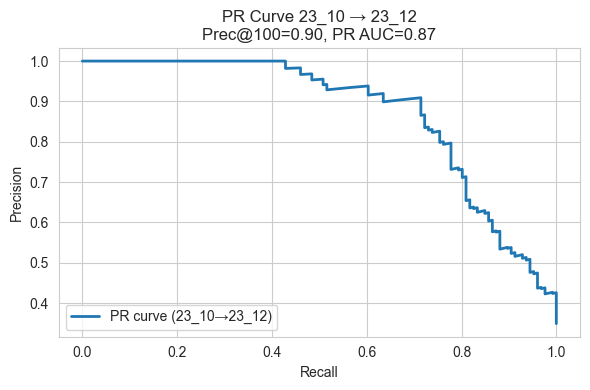

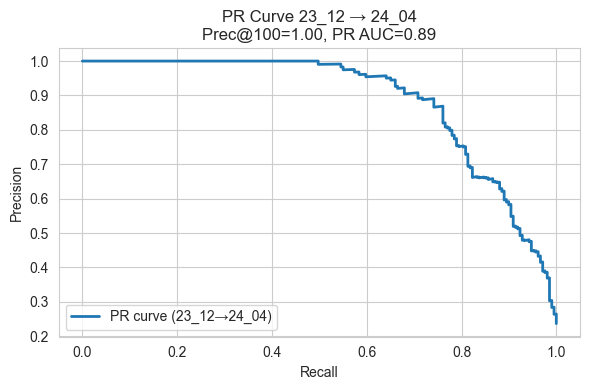

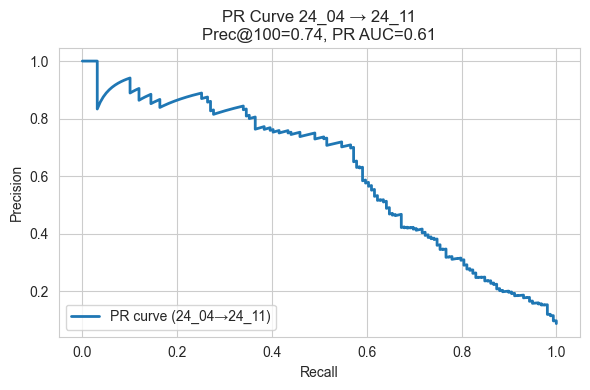

|   train |   test |   n_train |   n_test |   C_index |   ROC_AUC |   Prec@100 |   PR_AUC |
|--------:|-------:|----------:|---------:|----------:|----------:|-----------:|---------:|
|   23_10 |  23_12 |      1019 |      361 |  0.859444 |  0.897636 |       0.9  | 0.871856 |
|   23_12 |  24_04 |       361 |      883 |  0.875571 |  0.939545 |       1    | 0.886383 |
|   24_04 |  24_11 |       883 |     1821 |  0.917167 |  0.898626 |       0.74 | 0.614937 |


In [54]:
from sklearn.metrics import precision_recall_curve, roc_auc_score
K = 100  # топ-K студентов

# подготовка волновых префиксов
df_sa['wave_prefix'] = df_sa['wave_name'].str.split('_').str[:2].str.join('_')
prefixes = sorted(df_sa['wave_prefix'].dropna().unique())

# место для результатов
pr_results = []

for i in range(len(prefixes)-1):
    train_pref, test_pref = prefixes[i], prefixes[i+1]

    df_train = df_sa[df_sa['wave_prefix']==train_pref][['T','E']+honest_feats].dropna()
    df_test  = df_sa[df_sa['wave_prefix']==test_pref][['T','E']+honest_feats].dropna()
    if df_train.shape[0]<250 or df_test.shape[0]<250:
        continue

    #обучаем CoxPH
    cph = CoxPHFitter(penalizer=0.5)
    cph.fit(df_train, 'T','E')

    #получаем risk_score и y_true
    y_true  = df_test['E'].values
    risk_sc = cph.predict_partial_hazard(df_test).values.flatten()

    #precision@K
    n_test = len(y_true)
    k = min(K, n_test)
    top_k_idx = np.argsort(-risk_sc)[:k]
    prec_at_k = y_true[top_k_idx].mean()

    #PR-кривая и корректный PR AUC
    precision, recall, _ = precision_recall_curve(y_true, risk_sc)
    # ортируем по возрастанию recall, чтобы trapz не выдавало отрицательное значение
    idx_sort = np.argsort(recall)
    pr_auc = np.trapz(precision[idx_sort], recall[idx_sort])

    pr_results.append({
        'train':       train_pref,
        'test':        test_pref,
        'n_train':     df_train.shape[0],
        'n_test':      n_test,
        'C_index':     cph.concordance_index_,
        'ROC_AUC':     roc_auc_score(y_true, risk_sc),
        f'Prec@{k}':  prec_at_k,
        'PR_AUC':      pr_auc
    })

    # PR-кривая
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, lw=2, label=f'PR curve ({train_pref}→{test_pref})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(
        f'PR Curve {train_pref} → {test_pref}\n'
        f'Prec@{k}={prec_at_k:.2f}, PR AUC={pr_auc:.2f}'
    )
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

# итоговая табличка
df_pr = pd.DataFrame(pr_results)
print(df_pr.to_markdown(index=False))


## 14. Прогнозирование на новой волне от 25_04

Применяем обученную модель к данным новой когорты от апреля 2025 для оценки риска оттока.

In [55]:
#копируем данные и заменяем «Нет данных» на NaN
df_sa = df.copy()
df_sa.replace('Нет данных', np.nan, inplace=True)

#приводим даты в нужный формат и вычисляем t/e через разницу дат
df_sa['start_at'] = pd.to_datetime(df_sa['start_at'])
df_sa['deactivated_at'] = pd.to_datetime(df_sa['deactivated_at'], errors='coerce')

#дата цензуры (максимальная из deactivated_at)
censor_date = df_sa['deactivated_at'].max()

#event_time: если deactivated_at отсутствует, ставим censor_date
df_sa['event_time'] = df_sa['deactivated_at'].fillna(censor_date)

#считаем t (в днях) и e (1 = событие произошло, 0 = цензура)
df_sa['T'] = (df_sa['event_time'] - df_sa['start_at']).dt.days.clip(lower=1)
df_sa['E'] = df_sa['deactivated_at'].notna().astype(int)

#вычисляем per-day признаки на основе финального t
df_sa['xp_per_day'] = df_sa['all_xp'] / df_sa['T']
df_sa['events_per_day'] = df_sa['event_count'] / df_sa['T']
df_sa['verifier_sessions_per_day'] = df_sa['number_of_verifier_p2p'] / df_sa['T']
df_sa['verifier_minutes_per_day'] = df_sa['avg_verifier_minutes'] / df_sa['T']
df_sa['verifiable_minutes_per_day'] = df_sa['avg_verifiable_minutes'] / df_sa['T']
df_sa['fail_per_day'] = df_sa['fail'] / df_sa['T']
df_sa['in_progress_per_day'] = df_sa['in_progress'] / df_sa['T']
df_sa['attendance_per_day'] = df_sa['total_attendance'] / df_sa['T']

#приводим attendance_rate и risk_metric к числовому типу
df_sa['attendance_rate'] = pd.to_numeric(df_sa['attendance_rate'], errors='coerce')
df_sa['risk_metric'] = pd.to_numeric(df_sa['risk_metric'], errors='coerce')

#агрегаты посещаемости по месяцам (1–12)
months = [f'attendance_month{i}' for i in range(1, 13)]
for m in months:
    df_sa[m] = pd.to_numeric(df_sa[m], errors='coerce')

_month_idx = np.arange(1, 13)
df_sa['att_trend'] = df_sa[months].apply(
    lambda r: np.polyfit(_month_idx[~r.isna()], r.dropna(), 1)[0]
    if r.dropna().size > 1 else np.nan,
    axis=1
)
df_sa['att_dispersion'] = df_sa[months].std(axis=1)
df_sa['att_early'] = df_sa[[f'attendance_month{i}' for i in range(1, 5)]].mean(axis=1)
df_sa['att_middle'] = df_sa[[f'attendance_month{i}' for i in range(5, 9)]].mean(axis=1)
df_sa['att_late'] = df_sa[[f'attendance_month{i}' for i in range(9, 13)]].mean(axis=1)

#логарифмическое преобразование некоторых признаков
df_sa['log_verif_min_per_day'] = np.log1p(df_sa['verifier_minutes_per_day'])
df_sa['verifiable_minutes_per_day'] = np.log1p(df_sa['verifiable_minutes_per_day'])
df_sa['events_per_day'] = np.log1p(df_sa['events_per_day'])
df_sa['fail_per_day'] = np.log1p(df_sa['fail_per_day'])
df_sa['in_progress_per_day'] = np.log1p(df_sa['in_progress_per_day'])


In [56]:
#выбираем только новые волны (начинаются на '25_04')
df_new = df_sa[df_sa['wave_name'].str.startswith('25_04')].copy()
df_new['wave_prefix'] = (
    df_new['wave_name']
    .str.split('_').str[:2]
    .str.join('_')
)

#предсказываем относительный hazard (risk_score)
#уже обученный CoxPH cph_honest (или cph_full)
df_new['risk_score'] = cph.predict_partial_hazard(df_new[honest_feats]).values.flatten()

#вероятность отчисления за 250 дней от старта
#survival_function в t=250 и считаем 1-S(250)
surv_250 = cph.predict_survival_function(df_new[honest_feats], times=[250]).T
df_new['risk_250d'] = 1 - surv_250.iloc[:, 0]

#ранжируем и присваиваем уровень риска
df_new = df_new.sort_values('risk_score', ascending=False)

#квантили уровней риска (25/50/75%):
df_new['risk_level'] = pd.qcut(df_new['risk_score'],
                               q=[0, .25, .5, .75, 1],
                               labels=['low', 'med', 'high', 'very_high'])

#смотрим топ-100 самых рисковых:
top100 = df_new.head(100)[[
    'wave_name','ldap_login','risk_score','risk_250d','risk_level'
]]
print(top100.to_markdown(index=False))

#если хотите – сохранить результат:
df_new.to_csv('new_waves_with_risk.csv', index=False)


| wave_name   | ldap_login   |   risk_score |   risk_250d | risk_level   |
|:------------|:-------------|-------------:|------------:|:-------------|
| 25_04_SAKH  | chaseand     |    1526.42   |    1        | very_high    |
| 25_04_YKS   | janellam     |    1222.3    |    1        | very_high    |
| 25_04_MSK   | thomasba     |     557.176  |    1        | very_high    |
| 25_04_MSK   | meliansy     |     490.702  |    1        | very_high    |
| 25_04_KZN   | fetasylv     |     393.37   |    1        | very_high    |
| 25_04_NSK   | solomonk     |     327.551  |    1        | very_high    |
| 25_04_NN    | suzikris     |     322.962  |    1        | very_high    |
| 25_04_NOV   | presterc     |     302.517  |    1        | very_high    |
| 25_04_NSK   | beedlesh     |     289.691  |    1        | very_high    |
| 25_04_NN    | elainevi     |     281.604  |    1        | very_high    |
| 25_04_NSK   | fuseatre     |     280.473  |    1        | very_high    |
| 25_04_YAR   | jhogocla 

In [57]:
#горизонт для вероятности отчисления
t = 250  # дней

#выбираем только новые волны (начинаются на '25_04')
df_new = df_sa[df_sa['wave_name'].str.startswith('25_04_MSK')].copy()

#hazard (risk_score)
df_new['risk_score'] = cph.predict_partial_hazard(df_new[honest_feats]).values.flatten()

#вероятность отчисления к моменту t:
#    S(t | x) = survival_function, risk_t = 1 − S(t)
surv_t = cph.predict_survival_function(df_new[honest_feats], times=[t]).T
df_new[f'risk_prob_{t}d'] = 1 - surv_t.iloc[:, 0]

#ранжируем и квантильный уровень
df_new = df_new.sort_values('risk_score', ascending=False).reset_index(drop=True)
df_new['risk_rank']  = df_new.index + 1
df_new['risk_level'] = pd.qcut(
    df_new['risk_score'],
    q=[0, .25, .5, .75, 1],
    labels=['low', 'med', 'high', 'very_high']
)

top100 = df_new.head(100)[[
    'wave_name', 'ldap_login', 'risk_rank', 'risk_score', f'risk_prob_{t}d', 'risk_level'
]]
print(top100.to_markdown(index=False))

top100.to_excel('25_04_msk_with_risk.xlsx', index=False)


| wave_name   | ldap_login   |   risk_rank |   risk_score |   risk_prob_250d | risk_level   |
|:------------|:-------------|------------:|-------------:|-----------------:|:-------------|
| 25_04_MSK   | thomasba     |           1 |     557.176  |         1        | very_high    |
| 25_04_MSK   | meliansy     |           2 |     490.702  |         1        | very_high    |
| 25_04_MSK   | harrynak     |           3 |     241.646  |         1        | very_high    |
| 25_04_MSK   | hillmand     |           4 |     240.165  |         1        | very_high    |
| 25_04_MSK   | smithgeo     |           5 |     227.273  |         1        | very_high    |
| 25_04_MSK   | asougino     |           6 |     167.359  |         1        | very_high    |
| 25_04_MSK   | vanishej     |           7 |     162.458  |         1        | very_high    |
| 25_04_MSK   | sandmang     |           8 |     119.143  |         1        | very_high    |
| 25_04_MSK   | priscisl     |           9 |      99.9073 | 

In [58]:
risk = pd.read_excel('25_04_msk_with_risk.xlsx')

In [59]:
risk

,wave_name,ldap_login,risk_rank,risk_score,risk_prob_250d,risk_level
0,25_04_MSK,thomasba,1,557.175848,1.000000,very_high
1,25_04_MSK,meliansy,2,490.701874,1.000000,very_high
2,25_04_MSK,harrynak,3,241.646270,1.000000,very_high
3,25_04_MSK,hillmand,4,240.165100,1.000000,very_high
4,25_04_MSK,smithgeo,5,227.273123,1.000000,very_high
...,...,...,...,...,...,...
95,25_04_MSK,montgomm,96,17.940277,0.961311,med
96,25_04_MSK,deadposu,97,17.883991,0.960914,med
97,25_04_MSK,ryswellt,98,17.755148,0.959991,med
98,25_04_MSK,andriatu,99,17.684094,0.959472,med


## 15. Обучение моделей Random Survival Forest и Gradient Boosting

Обучаем две модели выживания: Random Survival Forest и Gradient Boosting Survival Analysis для сравнения их качества.

# Random Survival Forest (RSF)

## Краткая справка по модели

Random Survival Forest (RSF) — это нерегрессионный ансамблевый метод для анализа выживаемости, основанный на рандомизированных деревьях решений. Основные моменты:

- **Тип модели:** ансамбль случайных деревьев (bootstrap-aggregated trees) для данных времени до события.
- **Целевая переменная:** $(T, E)$, где
  - $T$ — время до события (например, отчисления);
  - $E \in \{0,1\}$ — индикатор цензуры (1, если событие произошло, 0, если пациент “дожил” до конца наблюдения).
- **Критерий расщепления:** в каждом узле дерева выбирается признак и порог, оптимизирующие критерий, основанный на логранговых тестах (log-rank split), который максимизирует разницу между кумулятивными функциями риска дочерних узлов.
- **Агрегация:** каждое дерево строится на случайной подвыборке наблюдений (bootstrap) и случайном подмножестве признаков при каждом расщеплении. Итоговый прогноз — усреднённая оценка (или агрегация кумулятивных функций риска) по всем деревьям.

## Применение к нашим данным

1. **Входные данные:**
   - Признаки $\mathbf{x} = (x_1, x_2, \dots, x_p)$ для каждого студента.
   - Время до события $T_i$ (число дней до отчисления или цензуры).
   - Индикатор события $E_i \in \{0,1\}$ (1, если студент отчислился, 0 — если цензирован).

2. **Построение модели:**
   - Для $b = 1,2,\dots,B$ деревьев:
     1. Генерируется bootstrap-выборка из исходных данных.
     2. Строится дерево, где в каждом узле:
        - Случайно выбирается подмножество признаков (обычно $\sqrt{p}$ или $p/3$).
        - Среди выбранных признаков и всех возможных порогов находится расщепление, максимизирующее статистику log-rank между двумя полученными группами.
        - Процесс продолжается рекурсивно до достижения критерия остановки (минимальное число наблюдений в листе или максимальная глубина).
   - В каждом листе дерева оценивается кумулятивная функция риска $\hat{H}_{b}^{(\text{leaf})}(t)$ или функция выживаемости $\hat{S}_{b}^{(\text{leaf})}(t)$, используя несмещённую оценку Каплана–Мейера для подмножества наблюдений, попавших в этот лист.

3. **Прогнозирование для нового наблюдения $\mathbf{x}^*$:**
   - Проходим по каждому дереву $b$:
     1. Отправляем $\mathbf{x}^*$ от корня к листу, применяя те же пороги в узлах.
     2. В листе извлекаем оценку $\hat{H}_{b}^{(\text{leaf})}(t)$ или $\hat{S}_{b}^{(\text{leaf})}(t)$.
   - Итоговая оценка кумулятивной функции риска:
     $$
     \hat{H}(t \mid \mathbf{x}^*) = \frac{1}{B} \sum_{b=1}^{B} \hat{H}_{b}^{(\text{leaf}^*(b))}(t),
     $$
     где $\text{leaf}^*(b)$ — лист дерева $b$, в котором оказалось $\mathbf{x}^*$.
   - Аналогично оценивается средняя функция выживаемости:
     $$
     \hat{S}(t \mid \mathbf{x}^*) = \frac{1}{B} \sum_{b=1}^{B} \hat{S}_{b}^{(\text{leaf}^*(b))}(t).
     $$

## Что даёт RSF

1. **Оценка функции выживания**
   - По каждому времени $t$ можно получить $\hat{S}(t \mid \mathbf{x})$ — вероятность того, что студент не будет отчислен к моменту $t$.
   - Кумулятивную функцию риска $\hat{H}(t \mid \mathbf{x}) = -\ln\bigl(\hat{S}(t \mid \mathbf{x})\bigr)$ можно использовать для сравнения риск-профилей студентов.

2. **Оценка “рангового” риска (risk score)**
   - Для упрощённого ранжирования можно вычислить совокупный риск-кратко, например, взять
     $$
     \text{RiskScore}(\mathbf{x}) = \sum_{t} \hat{H}(t \mid \mathbf{x}),
     $$
     или рассмотреть ожидаемое время до события, усреднённое по деревьям.

3. **Переменная важности (variable importance)**
   - RSF позволяет оценить важность признаков:
     - **Permutation importance**: для каждого признака случайно перемешивают его значения в OOB (out-of-bag) данных и измеряют падение качества (например, C-index).
     - **Minimal depth**: измеряет глубину, на которой признак впервые появляется в деревьях (чем ближе к корню, тем важнее признак).

4. **Метрика качества**
   - **Concordance Index (C-index)**: доля правильно упорядоченных пар по времени до события.
   - **Brier Score**: усреднённый квадрат ошибки в предсказанных вероятностях события к заданному времени.

## Пример интерпретации

- Допустим, у нас есть два признака: `attendance_rate` и `verifier_minutes_per_day`. После обучения RSF мы получили:
  - Для студентки А:
    - Оцененная функция выживаемости $\hat{S}_A(100)$ (вероятность продержаться 100 дней) = 0.85.
  - Для студента Б:
    - $\hat{S}_B(100) = 0.40$.

  Это означает, что модель оценивает ученицу А как менее “рисковую”: у неё 85% шанс не отчислиться в первые 100 дней, в то время как у ученика Б — лишь 40%.

- **Переменная важности** может показать, что `attendance_rate` является одним из наиболее влиятельных признаков (находится близко к корню многих деревьев), а `verifier_minutes_per_day` имеет более низкую важность.

## Преимущества и ограничения RSF

### Преимущества

1. **Обработка сложных нелинейных зависимостей и взаимодействий**
   - RSF автоматически “учится” учитывать взаимодействия между признаками и нелинейные зависимости, так как каждое дерево может разделять пространство признаков произвольным образом.

2. **Устойчивость к выбросам и шуму**
   - Объединение многих деревьев (bagging) снижает переобучение и делает модель более устойчивой.

3. **Кросс-проверка необходимости дополнительной предобработки**
   - Не требуется линейная трансформация признаков или строгая модельная спецификация. Работает с категориальными и числовыми признаками “из коробки”.

4. **Оценка важности признаков**
   - Предоставляет гибкие методы для ранжирования признаков по значимости.

### Ограничения

1. **Требует большого числа наблюдений**
   - Для построения множества деревьев необходимо достаточное количество наблюдений, особенно при большом количестве признаков.

2. **Менее интерпретируемая модель**
   - В отличие от CoxPH, здесь нет простых коэффициентов $\beta_i$. Труднее объяснить “насколько” каждый признак влияет на риск.

3. **Выбор гиперпараметров**
   - Нужно настроить глубину деревьев, количество деревьев, минимальное число наблюдений в листе и т. д. Обычно применяется кросс-валидация.

---

# Gradient Boosting Survival Analysis (GBSA)

## Краткая справка по модели

Gradient Boosting Survival Analysis — это адаптация метода градиентного бустинга (Gradient Boosting Machine, GBM) для данных выживаемости. Главное:

- **Тип модели:** бустинг последовательных слабых базовых алгоритмов (обычно небольших деревьев решений) с учётом функции потерь для выживаемости (часто используется отрицательный лог частичной правдоподобности CoxPH или специализированная квазилинейная функция потерь).
- **Идея:** каждое новое дерево обучается на градиенте функции потерь, связанной с текущими прогнозами риска, чтобы последовательно улучшать предсказания.
- **Прогнозируемая величина:** аналогично CoxPH — относительный лог-hazard $\eta(\mathbf{x}) = \mathbf{x} \cdot \beta$ (обобщённый скор), либо непосредственно функция риска или выживаемости с учётом накопленного вклада деревьев.

## Применение к нашим данным

1. **Входные данные:**
   - Признаки $\mathbf{x} = (x_1, x_2, \dots, x_p)$.
   - Пары $(T_i, E_i)$ для каждого студента.

2. **Функция потерь**
   - Часто используют **частичную правдоподобность CoxPH** в качестве “квазиправдоподобия”:
     $$
     \ell(\beta) = - \sum_{i:E_i=1} \left( \bigl(\mathbf{x}_i \cdot \beta\bigr) - \ln \sum_{j:T_j \ge T_i} e^{\mathbf{x}_j \cdot \beta} \right).
     $$
   - В GBSA вместо оценки $\beta$ напрямую строится ансамбль деревьев, прогнозирующий $\eta(\mathbf{x}) = \sum_{m=1}^{M} f_m(\mathbf{x})$, где $f_m$ — $m$-ое дерево.

3. **Итеративное обучение (градиентный бустинг)**
   - Инициализируем прогноз $\eta^{(0)}(\mathbf{x})$ (часто нули).
   - Для $m = 1,2,\dots,M$ (количество деревьев):
     1. Вычисляем “псевдоградиенты” (производные функции потерь по $\eta^{(m-1)}$) для каждого наблюдения.
     2. На обучающей выборке строим дерево $f_{m}(\mathbf{x})$, минимизирующее квадрат ошибки между псевдоградиентами и предсказанными значениями.
     3. Обновляем ансамбль:
        $$
        \eta^{(m)}(\mathbf{x}) = \eta^{(m-1)}(\mathbf{x}) + \nu \cdot f_{m}(\mathbf{x}),
        $$
        где $\nu$ (learning rate) — темп обучения (обычно $\nu \in [0.01, 0.3]$).
   - В итоге получаем комбинированный скор $\hat{\eta}(\mathbf{x})$.

4. **Переход к функции выживаемости**
   - В зависимости от реализации, модель может сразу оценивать базовую функцию риска $\hat{H}_{0}(t)$ (аналог базового риска CoxPH) и затем строить ансамбль для предсказания $\Delta H(t \mid \mathbf{x})$ (прирост кумулятивного риска).
   - Либо строят модель только для относительного скора $\eta(\mathbf{x})$, после чего прибегают к дополнительным оценкам базового риска (например, с помощью несмещённой оценки Каплана–Мейера на “стандартизованном” наборе).

5. **Прогнозирование для нового наблюдения $\mathbf{x}^*$:**
   - Получаем финальный относительный скор
     $$
     \hat{\eta}(\mathbf{x}^*) = \sum_{m=1}^{M} \nu\,f_{m}(\mathbf{x}^*).
     $$
   - Если модель была обучена по частичной правдоподобности CoxPH, можно оценить базовую кумулятивную функцию риска $\hat{H}_{0}(t)$ по обучающим данным и получить для $\mathbf{x}^*$:
     $$
     \hat{H}(t \mid \mathbf{x}^*) = \hat{H}_{0}(t)\,\exp\bigl(\hat{\eta}(\mathbf{x}^*)\bigr),
     $$
     а затем $\hat{S}(t \mid \mathbf{x}^*) = \exp\bigl(-\hat{H}(t \mid \mathbf{x}^*)\bigr)$.

## Что даёт GBSA

1. **Гибкость модели**
   - GBSA сочетает преимущества градиентного бустинга: учёт сложных нелинейностей и взаимодействий между признаками, при этом оптимизируя функцию потерь, напрямую связанную с выживаемостью.

2. **Относительный risk score**
   - Итоговый скор $\hat{\eta}(\mathbf{x})$ похож на линейную комбинацию признаков в CoxPH, но построен из энсамбля деревьев. Большие $\hat{\eta}(\mathbf{x})$ указывают на более высокий риск.

3. **Функции выживания и риска**
   - После оценки $\hat{\eta}(\mathbf{x})$ можно получить $ \hat{H}(t\mid \mathbf{x})$ и $ \hat{S}(t\mid \mathbf{x})$ аналогично CoxPH:
     $$
     \hat{H}(t \mid \mathbf{x}) = \hat{H}_{0}(t)\,\exp\bigl(\hat{\eta}(\mathbf{x})\bigr),
     \quad
     \hat{S}(t \mid \mathbf{x}) = \exp\bigl(-\hat{H}(t \mid \mathbf{x})\bigr).
     $$
   - Если модель реализует прямую оценку приращения риска (incremental hazard), прогноз агрегируется по деревьям и затем применяется к базовой оценке.

4. **Метрики качества**
   - **Concordance Index (C-index)** — измеряет способность модели правильно ранжировать пары наблюдений.
   - **Integrated Brier Score (IBS)** — интегрированное значение среднеквадратичной ошибки прогноза выживания по времени.

5. **Важность признаков**
   - GBSA может предоставить *feature importance* (часто основано на средних сокращениях функции потерь при разбиении по признаку) для оценки вклада каждого $x_i$.

## Пример интерпретации

- После обучения GBSA предположим, что для студента X:
  - $\hat{\eta}(X) = +0.8$,
  - Базовая кумулятивная функция риска $\hat{H}_{0}(100) = 0.5$ (оценено по трению).

  Тогда
  $$
  \hat{H}(100 \mid X) = 0.5 \times e^{0.8} \approx 0.5 \times 2.23 \approx 1.115,
  $$
  и функция выживаемости
  $$
  \hat{S}(100 \mid X) = e^{-1.115} \approx 0.33.
  $$
  То есть у студента X только ~33% шанса не отчислиться к 100 дню.

- **Feature importance** может показать, что `attendance_rate` снизило ошибку модели сильнее всех признаков, а `verifier_minutes_per_day` имеет менее значимый вклад.

## Преимущества и ограничения GBSA

### Преимущества

1. **Гибкость и высокая предсказательная способность**
   - Учитывает сложные нелинейные зависимости и взаимодействия без явной спецификации модели.
2. **Оптимизация релевантной функции потерь**
   - Обучается сразу на частичной функции потерь CoxPH или другой специализированной метрике для выживаемости, что повышает качество прогнозов по сравнению с “чистой” регрессией.
3. **Регуляризация через темп обучения и число деревьев**
   - Можно регулировать сложность модели (learning rate, глубина деревьев, количество деревьев), чтобы избежать переобучения.

### Ограничения

1. **Сложность настройки гиперпараметров**
   - Требуется тщательная кросс-валидация по числу деревьев, глубине, скорости обучения.
   - Неправильные значения могут привести к переобучению или недообучению.
2. **Интерпретируемость**
   - Как и в любых бустинговых ансамблях деревьев, трудно напрямую интерпретировать вклад каждого признака, хотя важность можно приблизительно оценить.
3. **Требования к объёму данных**
   - Для стабильной работы и надёжных оценок функций выживания надо достаточное количество наблюдений и событий (отчислений).

In [60]:
features_clean = [
    'verifier_minutes_per_day', # усредненная по дням длительность проверки как проверяющего
    'verifier_sessions_per_day', # количество проверок как проверяющего
    'attendance_rate', # посещаемость
    'risk_metric', # синтетическая метрика риска
    'att_dispersion', # дисперсия посещаемости по месяцам
    'att_late', # посещаемость в подние периоды учебы
    'events_per_day' # усредненное по дням количесвто регистраций на ивенты
]

In [61]:
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
from sklearn.model_selection import train_test_split

#подготовка y в формате structured array
y_struct = Surv.from_dataframe('E', 'T', df_model)
X = df_model[features_clean]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_struct, test_size=0.2, random_state=42)

#Random Survival Forest
rsf = RandomSurvivalForest(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=15,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
rsf.fit(X_train, y_train)
pred_rsf = rsf.predict(X_test)
ci_rsf, *_ = concordance_index_censored(
    y_test['E'], y_test['T'], pred_rsf
)
print("RSF C-index:", ci_rsf)


#Gradient‐Boosted Survival (CoxPH loss)
gbs = GradientBoostingSurvivalAnalysis(
    loss='coxph',
    learning_rate=0.1,
    n_estimators=200,
    max_depth=3,
    subsample=0.8,
    random_state=42
)
gbs.fit(X_train, y_train)
pred_gbs = gbs.predict(X_test)
ci_gbs, *_ = concordance_index_censored(
    y_test['E'], y_test['T'], pred_gbs
)
print("GBS (tree-based) C-index:", ci_gbs)


RSF C-index: 0.9025722658369812
GBS (tree-based) C-index: 0.9099706957056547


## 16. Поиск гиперпараметров (Grid Search)

Выполняем перебор параметров (Grid Search) для настройки моделей и улучшения их метрик.

In [63]:
from tqdm.auto import tqdm
from sklearn.model_selection import ParameterGrid, KFold
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv

#подготовка данных
X = df_model[features_clean].values
y_event = df_model['E'].values.astype(bool)
y_time  = df_model['T'].values

#сетка гиперпараметров
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators':  [100, 200, 500],
    'max_depth':     [3, 5],
    'subsample':     [0.6, 0.8, 1.0]
}
grid = list(ParameterGrid(param_grid))

#kFold для валидации
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#перебор с трекером
results = []
for i, params in enumerate(tqdm(grid, desc="Grid search", unit="comb")):
    ci_scores = []
    # индикатор по фолдам
    for fold, (train_idx, val_idx) in enumerate(tqdm(
            kf.split(X), desc=f" Params {i+1}/{len(grid)} folds", leave=False)):
        # готовим данные для фолды
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr = Surv.from_arrays(y_event[train_idx], y_time[train_idx])
        # обучаем
        model = GradientBoostingSurvivalAnalysis(**params, random_state=42)
        model.fit(X_tr, y_tr)
        # предсказываем hazard и считаем c-index
        pred = model.predict(X_val)
        ci, *_ = concordance_index_censored(
            y_event[val_idx], y_time[val_idx], pred
        )
        ci_scores.append(ci)
    # сохраняем метрики
    results.append({
        **params,
        'mean_cindex': np.mean(ci_scores),
        'std_cindex':  np.std(ci_scores)
    })

# результаты
df_grid = pd.DataFrame(results).sort_values('mean_cindex', ascending=False)
print(df_grid.head(10).to_markdown(index=False))

Grid search:   0%|          | 0/54 [00:00<?, ?comb/s]

 Params 1/54 folds: 0it [00:00, ?it/s]

 Params 2/54 folds: 0it [00:00, ?it/s]

 Params 3/54 folds: 0it [00:00, ?it/s]

 Params 4/54 folds: 0it [00:00, ?it/s]

 Params 5/54 folds: 0it [00:00, ?it/s]

 Params 6/54 folds: 0it [00:00, ?it/s]

 Params 7/54 folds: 0it [00:00, ?it/s]

 Params 8/54 folds: 0it [00:00, ?it/s]

 Params 9/54 folds: 0it [00:00, ?it/s]

 Params 10/54 folds: 0it [00:00, ?it/s]

 Params 11/54 folds: 0it [00:00, ?it/s]

 Params 12/54 folds: 0it [00:00, ?it/s]

 Params 13/54 folds: 0it [00:00, ?it/s]

 Params 14/54 folds: 0it [00:00, ?it/s]

 Params 15/54 folds: 0it [00:00, ?it/s]

 Params 16/54 folds: 0it [00:00, ?it/s]

 Params 17/54 folds: 0it [00:00, ?it/s]

 Params 18/54 folds: 0it [00:00, ?it/s]

 Params 19/54 folds: 0it [00:00, ?it/s]

 Params 20/54 folds: 0it [00:00, ?it/s]

 Params 21/54 folds: 0it [00:00, ?it/s]

 Params 22/54 folds: 0it [00:00, ?it/s]

 Params 23/54 folds: 0it [00:00, ?it/s]

 Params 24/54 folds: 0it [00:00, ?it/s]

 Params 25/54 folds: 0it [00:00, ?it/s]

 Params 26/54 folds: 0it [00:00, ?it/s]

 Params 27/54 folds: 0it [00:00, ?it/s]

 Params 28/54 folds: 0it [00:00, ?it/s]

 Params 29/54 folds: 0it [00:00, ?it/s]

 Params 30/54 folds: 0it [00:00, ?it/s]

 Params 31/54 folds: 0it [00:00, ?it/s]

 Params 32/54 folds: 0it [00:00, ?it/s]

 Params 33/54 folds: 0it [00:00, ?it/s]

 Params 34/54 folds: 0it [00:00, ?it/s]

 Params 35/54 folds: 0it [00:00, ?it/s]

 Params 36/54 folds: 0it [00:00, ?it/s]

 Params 37/54 folds: 0it [00:00, ?it/s]

 Params 38/54 folds: 0it [00:00, ?it/s]

 Params 39/54 folds: 0it [00:00, ?it/s]

 Params 40/54 folds: 0it [00:00, ?it/s]

 Params 41/54 folds: 0it [00:00, ?it/s]

 Params 42/54 folds: 0it [00:00, ?it/s]

 Params 43/54 folds: 0it [00:00, ?it/s]

 Params 44/54 folds: 0it [00:00, ?it/s]

 Params 45/54 folds: 0it [00:00, ?it/s]

 Params 46/54 folds: 0it [00:00, ?it/s]

 Params 47/54 folds: 0it [00:00, ?it/s]

 Params 48/54 folds: 0it [00:00, ?it/s]

 Params 49/54 folds: 0it [00:00, ?it/s]

 Params 50/54 folds: 0it [00:00, ?it/s]

 Params 51/54 folds: 0it [00:00, ?it/s]

 Params 52/54 folds: 0it [00:00, ?it/s]

 Params 53/54 folds: 0it [00:00, ?it/s]

 Params 54/54 folds: 0it [00:00, ?it/s]

|   learning_rate |   max_depth |   n_estimators |   subsample |   mean_cindex |   std_cindex |
|----------------:|------------:|---------------:|------------:|--------------:|-------------:|
|            0.2  |           5 |            500 |         0.8 |      0.933176 |   0.00772374 |
|            0.2  |           3 |            500 |         0.8 |      0.931483 |   0.00665233 |
|            0.2  |           5 |            500 |         0.6 |      0.931044 |   0.00872607 |
|            0.2  |           3 |            500 |         0.6 |      0.930265 |   0.00547211 |
|            0.2  |           5 |            200 |         0.8 |      0.930125 |   0.00737251 |
|            0.1  |           5 |            500 |         0.6 |      0.930105 |   0.00629876 |
|            0.1  |           5 |            500 |         0.8 |      0.93002  |   0.00782843 |
|            0.2  |           3 |            500 |         1   |      0.927945 |   0.0073767  |
|            0.2  |           5 |       

# Обучаем лучшую модель по итогам гридсерча

In [74]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
from sklearn.model_selection import train_test_split

#исходные массивы
X = df_model[features_clean]
y_event = df_model['E'].values.astype(bool)
y_time  = df_model['T'].values

#сначала — train_val / test split (80% / 20%)
X_train_val, X_test, \
    y_event_train_val, y_event_test, \
    y_time_train_val,  y_time_test = train_test_split(
    X, y_event, y_time,
    test_size=0.20,
    random_state=42,
    stratify=y_event
)

#внутри train_val делим на train / val (75% / 25% от train_val → итог 60/20/20)
X_train, X_val, \
    y_event_train, y_event_val, \
    y_time_train,  y_time_val = train_test_split(
    X_train_val, y_event_train_val, y_time_train_val,
    test_size=0.25,        # 25% от 80% = 20% всей выборки
    random_state=42,
    stratify=y_event_train_val
)

#survival-массивы
y_train_struct = Surv.from_arrays(y_event_train, y_time_train)
y_val_struct   = Surv.from_arrays(y_event_val,   y_time_val)
y_test_struct  = Surv.from_arrays(y_event_test,  y_time_test)

#обучаем финальную модель на train
best_params = {
    'loss': 'coxph',
    'learning_rate': 0.2,
    'n_estimators': 500,
    'max_depth': 5,
    'subsample': 0.6,
    'random_state': 42
}
model = GradientBoostingSurvivalAnalysis(**best_params)
model.fit(X_train, y_train_struct)

#оценка на validation
pred_val = model.predict(X_val)
ci_val, *_ = concordance_index_censored(y_event_val, y_time_val, pred_val)
print(f"Validation C-index: {ci_val:.4f}")

#оценка на тесте
pred_test = model.predict(X_test)
ci_test, *_ = concordance_index_censored(y_event_test, y_time_test, pred_test)
print(f"Test C-index:       {ci_test:.4f}")


Validation C-index: 0.9337
Test C-index:       0.9285


## сохраняем итоговую модель

In [75]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.util import Surv

# оставляем structured-массив y на всём датасете
y_struct_full = Surv.from_arrays(
    df_model['E'].values.astype(bool),
    df_model['T'].values
)
# 2) Инициализируем модель с вашими лучшими гиперпараметрами
best_params = {
    'loss': 'coxph',
    'learning_rate': 0.2,
    'n_estimators': 500,
    'max_depth': 5,
    'subsample': 0.6,
    'random_state': 42
}
final_model = GradientBoostingSurvivalAnalysis(**best_params)

# 3) Тренируем на полном датасете
final_model.fit(df_model[features_clean], y_struct_full)

# Проверка
print("Модель обучена и сохранена в переменной final_model")

Модель обучена и сохранена в переменной final_model


# Проверка «калибровки» (calibration) градиентного бустинга для survival‐анализа с помощью 5-кратной кросс-валидации
Насколько предсказанные вероятности наступления события (оттока) до фиксированного горизонта τ (здесь 250 дней) соответствуют наблюдаемой частоте события.

/Users/a.fedorova/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(


Fold 1: events=130, bins=5


/Users/a.fedorova/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(


Fold 2: events=119, bins=5


/Users/a.fedorova/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(


Fold 3: events=119, bins=5


/Users/a.fedorova/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(


Fold 4: events=135, bins=5
Fold 5: events=125, bins=5


/Users/a.fedorova/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(


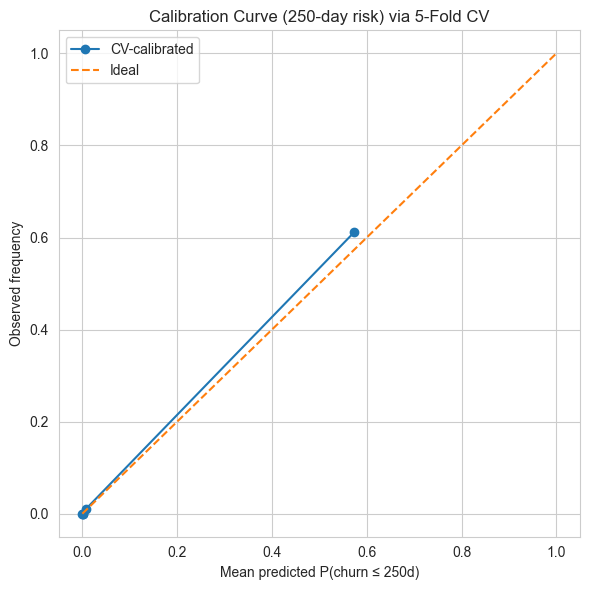

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.calibration import calibration_curve
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv

#параметры модели и горизонт
best_params = {
    'loss':          'coxph',
    'learning_rate': 0.2,
    'n_estimators':  500,
    'max_depth':     5,
    'subsample':     0.6,
    'random_state':  42
}
tau = 250  # дней

#все данные
X_all    = df_model[features_clean].values
y_event  = df_model['E'].values.astype(bool)
y_time   = df_model['T'].values

#KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_prob_true = []
all_prob_pred = []

#цикл по фолдам
for fold, (train_idx, val_idx) in enumerate(kf.split(X_all), start=1):
    #сплит
    X_tr, X_val = X_all[train_idx], X_all[val_idx]
    y_e_tr, y_e_val = y_event[train_idx], y_event[val_idx]
    y_t_tr, y_t_val = y_time[train_idx],  y_time[val_idx]

    #survival-массив и обучение
    y_tr_struct = Surv.from_arrays(y_e_tr, y_t_tr)
    model = GradientBoostingSurvivalAnalysis(**best_params)
    model.fit(X_tr, y_tr_struct)

    #survival-функции на валидации
    X_val_df = pd.DataFrame(X_val, columns=features_clean)
    surv_fns = model.predict_survival_function(X_val_df)

    #risk_tau = 1 − S(tau)
    risk_tau = np.array([1 - fn(tau) for fn in surv_fns])

    #формируем метки для calibration-curve
    mask = ~((y_t_val < tau) & (~y_e_val))
    y_true = (y_t_val <= tau) & y_e_val

    #calibration для этой фолды
    prob_true, prob_pred = calibration_curve(
        y_true[mask],
        risk_tau[mask],
        n_bins=5,
        strategy='quantile'
    )
    all_prob_true.append(prob_true)
    all_prob_pred.append(prob_pred)

    print(f"Fold {fold}: events={y_e_val.sum()}, bins={len(prob_true)}")

#усредняем по фолдам
mean_true = np.mean(all_prob_true, axis=0)
mean_pred = np.mean(all_prob_pred, axis=0)

#рисуем итоговую кривую
plt.figure(figsize=(6,6))
plt.plot(mean_pred, mean_true, 'o-', label='CV-calibrated')
plt.plot([0,1],[0,1],'--', label='Ideal')
plt.xlabel(f'Mean predicted P(churn ≤ {tau}d)')
plt.ylabel('Observed frequency')
plt.title(f'Calibration Curve ({tau}-day risk) via 5-Fold CV')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# бутстрэп-калибровка survival-модели


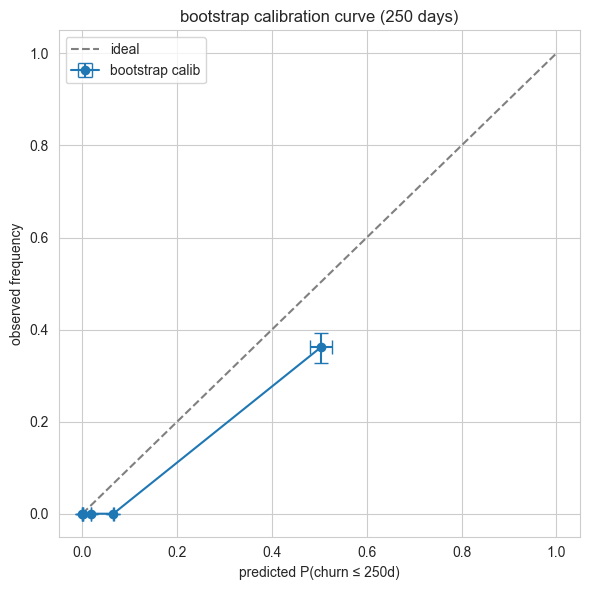

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# параметры
tau=250      # горизонт (дни)
n_bins=5     # число бинов
n_boot=200   # число bootstrap-реплик (можно увеличить)

# получаем предсказанный риск на полном датасете
X_full=df_model[features_clean]
surv_full=final_model.predict_survival_function(X_full)  # final_model должен быть уже обучен
risk_full=np.array([1 - fn(tau) for fn in surv_full])

# фиксируем границы бинов по квантилям из полных данных
bin_edges=np.quantile(risk_full, np.linspace(0, 1, n_bins + 1))

# создаём матрицы для накопления результатов
pred_mat=np.full((n_boot, n_bins), np.nan)
obs_mat=np.full((n_boot, n_bins), np.nan)

# bootstrap-цикл
for i in range(n_boot):
    # выборка с возвращением
    idx=np.random.choice(len(df_model), size=len(df_model), replace=True)
    df_boot=df_model.iloc[idx]

    # считаем риск на bootstrap-выборке
    surv_b=final_model.predict_survival_function(df_boot[features_clean])
    risk_b=np.array([1 - fn(tau) for fn in surv_b])

    # true-метки оттока до tau
    y_true_b=((df_boot['T'].values <= tau) & (df_boot['E'].values.astype(bool))).astype(int)

    # биним по предсказанному риску
    # digitize возвращает индексы от 1 до n_bins, вычитаем 1, чтобы было 0..n_bins-1
    bins=np.digitize(risk_b, bins=bin_edges[1:-1], right=True)

    # в каждом бине считаем среднее pred и среднее obs
    for b in range(n_bins):
        mask=bins == b
        if mask.sum() > 0:
            pred_mat[i, b]=risk_b[mask].mean()
            obs_mat[i, b]=y_true_b[mask].mean()

# усредняем по фолдам и строим доверительные интервалы
pred_mean=np.nanmean(pred_mat, axis=0)
pred_low=np.nanpercentile(pred_mat, 2.5, axis=0)
pred_high=np.nanpercentile(pred_mat, 97.5, axis=0)

obs_mean=np.nanmean(obs_mat, axis=0)
obs_low=np.nanpercentile(obs_mat, 2.5, axis=0)
obs_high=np.nanpercentile(obs_mat, 97.5, axis=0)

# считаем центры бинов для графика
bin_centers=(bin_edges[:-1] + bin_edges[1:]) / 2

# рисуем с ошибками
plt.figure(figsize=(6, 6))
plt.errorbar(
    pred_mean, obs_mean,
    xerr=[pred_mean - pred_low, pred_high - pred_mean],
    yerr=[obs_mean - obs_low, obs_high - obs_mean],
    fmt='o-', capsize=5, label='bootstrap calib'
)
plt.plot([0, 1], [0, 1], '--', color='gray', label='ideal')
plt.xlabel(f'predicted P(churn ≤ {tau}d)')
plt.ylabel('observed frequency')
plt.title(f'bootstrap calibration curve ({tau} days)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Прогноз времени отчисления моделью на волне 23_12

In [78]:
df_new = df_sa[df_sa['wave_name'].str.startswith('23_12')].copy()

#отбираем честные признаки и строим матрицу x_new
features_present = [f for f in features_clean if f in df_new.columns]
X_new_raw = df_new[features_present]

#заполняем пропуски медианой из обучающего датасета
imp = SimpleImputer(strategy='median')
imp.fit(df_model[features_present])   #учим импьютер на train-данных
X_new = imp.transform(X_new_raw)      #замена nan медианой

#предсказываем функции выживаемости для новых данных
surv_fns = final_model.predict_survival_function(X_new)

#извлекаем временную сетку из атрибута x первой функции
time_grid = surv_fns[0].x

#вычисляем для каждой функции медиану, 25-й перцентиль и матожидание времени до оттока
medians, p25s, means = [], [], []
for fn in surv_fns:
    S = fn.y  #значения S(t) на time_grid

    #находим медиану (первое t, где S(t) <= 0.5)
    idx_med = np.where(S <= 0.5)[0]
    medians.append(time_grid[idx_med[0]] if idx_med.size else np.nan)

    #находим 25-й перцентиль (первое t, где S(t) <= 0.75)
    idx_p25 = np.where(S <= 0.75)[0]
    p25s.append(time_grid[idx_p25[0]] if idx_p25.size else np.nan)

    #математическое ожидание: интеграл S(t) dt
    means.append(np.trapz(S, time_grid))

#добавляем результаты предсказаний в df_new
df_new['predicted_churn_time_median'] = medians
df_new['predicted_churn_time_25pct']  = p25s
df_new['predicted_churn_time_mean']   = means

#формируем итоговую табличку для просмотра
dd = df_new[[
    'ldap_login', 'wave_name',
    'predicted_churn_time_median',
    'predicted_churn_time_25pct',
    'predicted_churn_time_mean', 'days_till_deactivation'
]]

dd


/Users/a.fedorova/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingSurvivalAnalysis was fitted with feature names
  warnings.warn(


,ldap_login,wave_name,predicted_churn_time_median,predicted_churn_time_25pct,predicted_churn_time_mean,days_till_deactivation
6003,milfordn,23_12_MSK,NaN,NaN,556.678282,NaN
6004,miklazmo,23_12_MSK,153.0,137.0,138.532282,97.0
6005,miguelib,23_12_MSK,210.0,198.0,181.216324,210.0
6006,bryanaer,23_12_MSK,NaN,472.0,515.459376,NaN
6007,mernahor,23_12_MSK,366.0,318.0,350.305258,388.0
...,...,...,...,...,...,...
6483,minnaepi,23_12_NOV,NaN,NaN,538.197670,NaN
6484,elouiseb,23_12_MSK,NaN,NaN,552.231254,NaN
6485,millyaly,23_12_NOV,NaN,NaN,555.305091,NaN
6486,melwysfi,23_12_MSK,NaN,NaN,553.574964,NaN


## формируем финальный отчет для подгрузки в БД

In [79]:
tau = 250
df_score = df_sa.copy()

features_present = [f for f in features_clean if f in df_score.columns]
X_score_raw = df_score[features_present]

imp = SimpleImputer(strategy='median')
imp.fit(df_model[features_present])
X_score = imp.transform(X_score_raw)

surv_all = final_model.predict_survival_function(X_score)
time_grid = surv_all[0].x

risk_values = []
for fn in surv_all:
    S_vals = fn.y
    if tau <= time_grid[0]:
        risk = 1 - S_vals[0]
    elif tau >= time_grid[-1]:
        risk = 1 - S_vals[-1]
    else:
        idx = np.searchsorted(time_grid, tau, side='left')
        risk = 1 - S_vals[idx]
    risk_values.append(risk)

df_score[f'risk_{tau}d'] = risk_values
df_score_sorted = df_score.sort_values(by=f'risk_{tau}d', ascending=False).reset_index(drop=True)

top100 = df_score_sorted.head(100)[['ldap_login', 'wave_name', 'state', f'risk_{tau}d']]
top100

/Users/a.fedorova/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingSurvivalAnalysis was fitted with feature names
  warnings.warn(


,ldap_login,wave_name,state,risk_250d
0,batchwil,25_05_MAG,1,1.0
1,elodiale,24_11_MSK,1,1.0
2,shanaebu,24_11_NOV,1,1.0
3,krystynk,25_04_CHEL,1,1.0
4,hawkeder,24_11_MSK,0,1.0
...,...,...,...,...
95,adelefer,25_04_MSK,1,1.0
96,ilynpatt,23_10_MSK,0,1.0
97,skipjase,25_04_YAR,1,1.0
98,cheetaht,25_04_KZN,1,1.0


In [80]:
cols = ['ldap_login', 'wave_name', 'state', 'number_of_verifier_p2p', 'avg_verifier_minutes', 'mean_day_xp', 'total_attendance', 'deactivated_at', 'risk_250d']

In [81]:
to_dwh = df_score_sorted[cols]

## Загружаем результирующий датасет для бизнеса в БД

In [82]:
# from sqlalchemy import create_engine, text

In [83]:
# dwh = create_engine("placeholder")

In [ ]:
 # to_dwh.to_sql(
 #    'churn_probability',
 #    dwh,
 #    schema='public',
 #    if_exists='replace',
 #    index=False
# )